In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

import generate

In [7]:
Q, x = generate.qubo_matrix(20,1)
Q

array([[ 0.65323528,  0.99635553,  0.58190154,  0.329838  ,  0.13392378,
         0.03007693,  0.40024096,  0.51939987,  0.03335896,  0.56791055,
         0.27766099,  0.76395816,  0.11654066,  0.66828017,  0.49933894,
         0.30580931,  0.41432988,  0.90505738,  0.59736436,  0.23466049],
       [ 0.01344209,  0.67021064,  0.11269284,  0.5830051 ,  0.69695371,
         0.58349416,  0.90825824,  0.21783351,  0.41359502,  0.59676682,
         0.53070408,  0.09491557,  0.05073174,  0.94280763,  0.30754501,
         0.33531774,  0.74364707,  0.88347117,  0.93620854,  0.62118856],
       [ 0.07084113,  0.02954427,  0.98195198,  0.05389826,  0.01407361,
         0.69344378,  0.19257963,  0.62924358,  0.94858805,  0.47392412,
         0.30514208,  0.12000267,  0.71785936,  0.56633881,  0.34063319,
         0.59383066,  0.10727665,  0.29708226,  0.83097695,  0.58232351],
       [ 0.84840292,  0.53124526,  0.19338235,  0.30360964,  0.24770085,
         0.35640158,  0.38927336,  0.60389578,  

In [8]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [17]:
shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="COBYLA",
    tol=1e-9,
    options={"maxiter": 50000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

/Users/targuelles/Library/Caches/pypoetry/virtualenvs/basic-qubo-2hUiBxcz-py3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:719: OptimizeWarning: Unknown solver options: maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


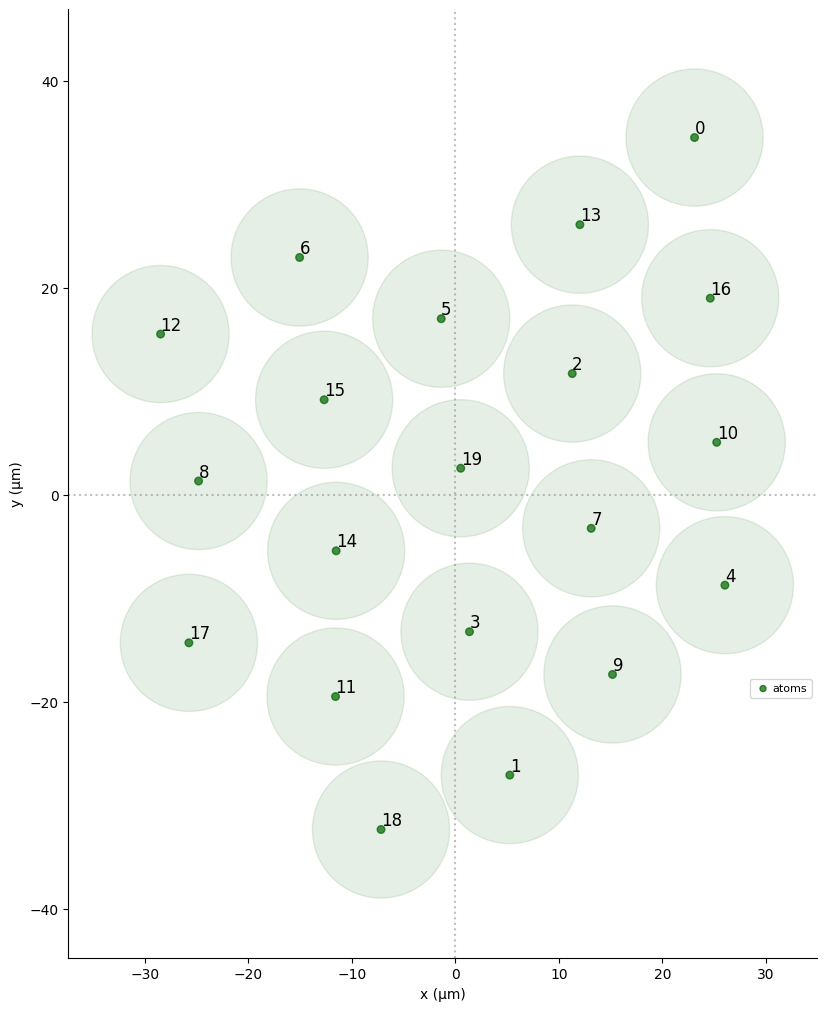

In [18]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1),
    draw_graph=False,
    draw_half_radius=True,
)

In [19]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [20]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = []  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

In [25]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -1.0002  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

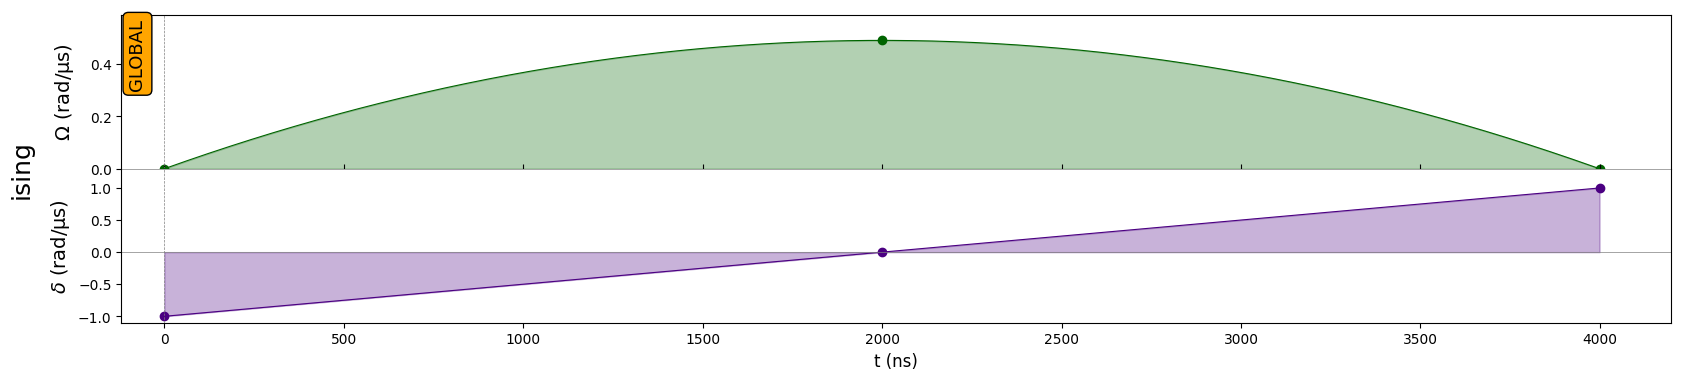

In [26]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [27]:
simul = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()
plot_distribution(count_dict)

KeyboardInterrupt: 

In [16]:
count_dict.most_common()[:3:1]

NameError: name 'count_dict' is not defined